# Analyzing fiber size distribution

Vincent Ouazan-Reboul, 2025/04/07

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import config as cfg
from scipy.optimize import fsolve

In [37]:
## Parameters - lifted from 00

model_params = cfg.load_model_file("input/face_0_model_params.json")
mc_params = cfg.load_model_file("input/face_0_mc_params.json")

n_particles = model_params["n_particles"][0]
n_sites = model_params["lx"] * model_params["ly"] * model_params["lz"]
phi_tot = n_particles / n_sites 

T_i, T_f, N_T = mc_params["Ti"], mc_params["Tf"], mc_params["Nt"]
T_values = np.logspace(T_i, T_f, N_T)
beta_values = 1 / T_values

e_per_bond = -1

In [173]:
# Theoretical distribution is pretty easily calculated
N_ORIENTATIONS = 24

def e_per_p(n, e_per_bond = e_per_bond):
    return e_per_bond * (n-1) / n

def c_n_theo(n, T, c_1, e_per_bond = e_per_bond, n_orientations = N_ORIENTATIONS):
    return n_orientations * (
        c_1 / n_orientations * np.exp(-e_per_p(n, e_per_bond) / T)
    ) ** n

def solve_for_c_1(
    T,
    init_guess = 1e-5,
    n_particles = n_particles,
    n_sites = n_sites,
    e_per_bond = e_per_bond,
    n_orientations = N_ORIENTATIONS
):
    def f(c_1):
        c_tot = 0.0
        # +1 because range stops at end-1
        n_range = np.linspace(1, n_particles+1, 1000)
        # for n in range(1, n_particles+1):
        for n in n_range:
            c_tot += n * c_n_theo(n, T, c_1, e_per_bond, n_orientations)
        return c_tot - n_particles / n_sites

    return fsolve(f, init_guess, maxfev = 1000)[0]

def solve_for_c_1_iter(
    T_range,
    init_guess = 1e-5,
    n_particles = n_particles,
    n_sites = n_sites,
    e_per_bond = e_per_bond,
    n_orientations = N_ORIENTATIONS,
    verbose = False
):
    new_guess = init_guess
    for T in T_range:
        new_guess = solve_for_c_1(T, new_guess, n_particles, n_sites, e_per_bond, n_orientations)
        if verbose:
            print(f"Guess at T={T}: {new_guess:e}")
    return new_guess

In [178]:
T_range = np.logspace(0, -3, 200)
c_1 = solve_for_c_1_iter(T_range)

/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_29140/141395125.py:26: RuntimeWarning: overflow encountered in multiply
  c_tot += n * c_n_theo(n, T, c_1, e_per_bond, n_orientations)
/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_29140/141395125.py:8: RuntimeWarning: overflow encountered in multiply
  return n_orientations * (
/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_29140/141395125.py:8: RuntimeWarning: overflow encountered in power
  return n_orientations * (
/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_29140/141395125.py:29: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(f, init_guess, maxfev = 1000)[0]
/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_29140/141395125.py:9: RuntimeWarning: overflow encountered in exp
  c_1 / n_orientations * np.exp(-e_per_p(n, e_per_bond) / T)


In [179]:
c_1

2.342419971795411e-226

In [175]:
c_1

2.342419971795411e-226

In [176]:
def calc_mean_energy_per_p(T, c_1, n_particles = n_particles, e_per_bond = e_per_bond):
    tot_e = 0.0
    for n in range(1, n_particles+1):
        tot_e += n * c_n_theo(n, T, c_1, e_per_bond=e_per_bond) * e_per_p(n, e_per_bond = e_per_bond)
        print(tot_e)
    return tot_e / n_particles

In [177]:
calc_mean_energy_per_p(1e-3, c_1)

0.0
-4.5040187110549085e-19
-1.7320706614349353e+189
-inf
-inf
-inf
-inf
-inf
-inf
-inf


/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_29140/141395125.py:9: RuntimeWarning: overflow encountered in exp
  c_1 / n_orientations * np.exp(-e_per_p(n, e_per_bond) / T)


-inf

In [4]:
# Getting data
# Mean number of dimers is just mean energy / e

n_orientations = 24

all_averages = {}
path_to_data = Path("./data")

for face in range(n_orientations):
    this_run_folder = path_to_data / f"dimer_face_{face}/average_energy"
    for average_file in this_run_folder.iterdir():
        (this_T, mean_e, _) = np.loadtxt(average_file)
        if this_T not in all_averages.keys():
            all_averages[this_T] = mean_e
        else:
            all_averages[this_T] += mean_e
all_T = [] 
all_av_e = []

for T in np.sort(list(all_averages.keys())):
    all_T.append(T)
    all_av_e.append(all_averages[T] / n_orientations)

all_T = np.array(all_T)
all_av_e = np.array(all_av_e)

all_av_phi2 = all_av_e / (- e_dimer) / n_sites

Text(0, 0.5, 'Total energy')

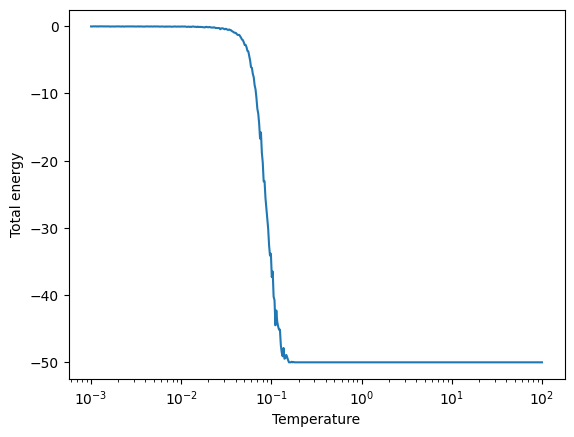

In [5]:
fig, ax = plt.subplots()

ax.semilogx(T_values, all_av_e)
ax.set_xlabel("Temperature")
ax.set_ylabel("Total energy")
# ax.plot(all_T, all_av_phi2, "o", alpha=0.2)


/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_16150/4058998187.py:5: RuntimeWarning: overflow encountered in exp
  return (-1 + np.sqrt(1 + phi_tot * np.exp(e / T) / 3)) / (np.exp(e / T) / 6)
/var/folders/v3/gbqhvbxs6nz1258v43493tx40000gp/T/ipykernel_16150/4058998187.py:5: RuntimeWarning: invalid value encountered in divide
  return (-1 + np.sqrt(1 + phi_tot * np.exp(e / T) / 3)) / (np.exp(e / T) / 6)


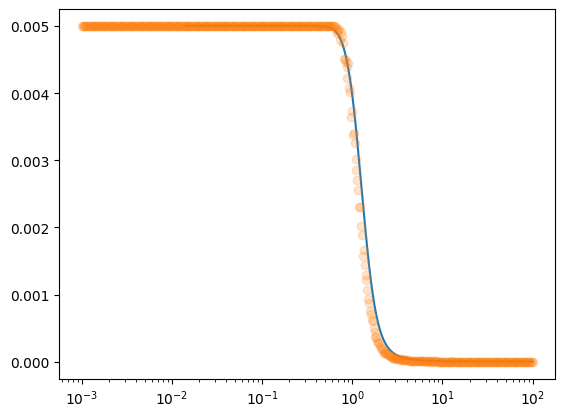

In [6]:
fig, ax = plt.subplots()

ax.semilogx(T_values, phi_2_theo(phi_tot, T_values), label = "Theory values")
ax.plot(all_T, all_av_phi2, "o", alpha=0.2, label = "Simulation results")
